In [66]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [61]:
df = pd.read_csv('arquivos\dadosalunos-limpo.csv')

C:\Users\romul\AppData\Local\Temp\ipykernel_20004\1396285713.py:1: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('arquivos\dadosalunos-limpo.csv')


In [3]:
df.columns

Index(['ANO_OCORRENCIA', 'CD_ALUNO', 'CD_CURSO', 'CD_ORIGEM_ALUNO', 'CD_TURNO',
       'DE_NATURALIDADE', 'DH_MATRICULA', 'DH_SITUACAO', 'DT_ANO_INGRES',
       'DT_NASC_ALUNO', 'LT_ESTADO_CIVIL', 'LT_MODALIDADE', 'LT_NACIONALIDADE',
       'LT_RACA', 'NM_CIDADE_AULA', 'NM_CIDADE_EST2GRAU', 'NM_CIDADE_FERIAS',
       'NM_CIDADE_NASC', 'NM_PAIS_NASC', 'NU_SEMESTRE2_VEST', 'SG_SEXO_ALUNO',
       'SG_UF_AULA', 'SG_UF_EST2GRAU', 'SG_UF_FERIAS', 'SG_UF_NASC_ALUNO',
       'ST_ALUNO', 'TP_DEFIC_INEP', 'TP_ESCOLA', 'TP_INGRES_CURSO',
       'TP_OPCAO_COTAS', 'F_CD_ORIGEM_ALUNO', 'F_DT_NASC_ALUNO',
       'F_NM_PAIS_NASC', 'F_NU_SEMESTRE2_VEST', 'F_SG_UF_FERIAS',
       'F_SG_UF_NASC_ALUNO', 'BOOL_TRANCADO', 'BOOL_ST_ALUNO',
       'MULTI_ST_ALUNO', 'BOOL_DEFIC_INEP', 'F_TP_ESCOLA', 'F_TP_OPCAO_COTAS',
       'BOOL_COTAS', 'IDADE_MATRICULA', 'ANO_NASCIMENTO',
       'MESES_ATE_ULTIMA_SITUACAO', 'NM_CURSO', 'TP_HABILITACAO', 'SG_CENTRO',
       'NM_CAMPUS', 'MAX_ANOS', 'BOOL_SEDE', 'LOCAL_FERI

In [4]:
colunas_excluir_ml = ['NM_CAMPUS', 
                      'SG_CENTRO', 
                      'NM_CURSO',
                      'GERACAO_COMPLETA', 
                      'NUMERO_GERACAO', 
                      'BOOL_ST_ALUNO', 
                      'MULTI_ST_ALUNO']
colunas_ml = ['CD_CURSO',
         'CD_TURNO',
         'LT_ESTADO_CIVIL',
         'LT_RACA',
         'F_NU_SEMESTRE2_VEST',
         'SG_SEXO_ALUNO',
         'BOOL_DEFIC_INEP',
         'F_TP_ESCOLA',
         'BOOL_COTAS',
         'IDADE_MATRICULA',
         'LOCAL_FERIAS',
         'LOCAL_NASC']
target_bool = 'BOOL_ST_ALUNO'
target_multi = 'MULTI_ST_ALUNO'

In [5]:
df = df[colunas_ml + colunas_excluir_ml].copy()

In [6]:
df = df.dropna()
df.shape[0]

66820

### Preparação do Dataset

In [7]:
pd.cut(df['IDADE_MATRICULA'], bins=[0, 16, 18, 20, 22, 24, 26, 30, 40, 50, 60, 70]).value_counts()

IDADE_MATRICULA
(16, 18]    36249
(18, 20]    14251
(20, 22]     5671
(22, 24]     3226
(26, 30]     2130
(24, 26]     1879
(30, 40]     1786
(0, 16]       935
(40, 50]      554
(50, 60]      128
(60, 70]       10
Name: count, dtype: int64

In [8]:
df['IDADE_MATRICULA'] = pd.cut(df['IDADE_MATRICULA'], bins=[0, 16, 18, 20, 22, 24, 26, 30, 40, 50, 60, 70]).value_counts()

In [9]:
from sklearn.preprocessing import LabelEncoder

In [10]:
for coluna in colunas_ml:
    le = LabelEncoder()
    df[coluna] = le.fit_transform(df[coluna])

### Modelos

In [78]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.svm import SVC

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV

from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

import xgboost as xgb

In [ ]:
X = df.drop(colunas_excluir_ml, axis=1)
y = df[target_bool]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [79]:
len(X_train), len(X_test), sum(y_train), sum(y_test)

(53456, 13364, 19466.0, 4867.0)

In [ ]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

#### Árvore de Decisão e Floresta Aleatória

In [15]:
dt = DecisionTreeClassifier(random_state=42)
rf = RandomForestClassifier(random_state=42)

In [48]:
# param_grid_dt = {
#     'criterion': ['gini', 'entropy'],
#     'max_depth': [3, 5, 7, 10],
#     'min_samples_split': [2, 5, 10]
# }

# param_grid_rf = {
#     'n_estimators': [10, 50, 100],
#     'criterion': ['gini', 'entropy'],
#     'max_depth': [3, 5, 7, 10],
#     'min_samples_split': [2, 5, 10]
# }

param_grid_dt = {
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 5, 10]
}

param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 5, 10],
    'bootstrap': [True, False]
}

In [49]:
grid_search_dt = GridSearchCV(estimator=dt, param_grid=param_grid_dt, cv=cv, n_jobs=-1, verbose=2)
grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid_rf, cv=cv, n_jobs=-1, verbose=2)

In [50]:
grid_search_dt.fit(X_train, y_train)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


c:\Users\romul\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
180 fits failed out of a total of 360.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
138 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\romul\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\romul\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "c:\Users\romul\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [10, 20, 30, None],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 5, 10],
                         'min_samples_split': [2, 10, 20]},
             verbose=2)

In [51]:
grid_search_rf.fit(X_train, y_train)

Fitting 5 folds for each of 432 candidates, totalling 2160 fits


c:\Users\romul\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
1080 fits failed out of a total of 2160.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
789 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\romul\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\romul\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "c:\Users\romul\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ba

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'max_depth': [10, 20, 30, None],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 5, 10],
                         'min_samples_split': [2, 10, 20],
                         'n_estimators': [100, 200, 300]},
             verbose=2)

In [53]:
y_pred_dt = grid_search_dt.best_estimator_.predict(X_test)
y_pred_rf = grid_search_rf.best_estimator_.predict(X_test)

In [54]:
print("Melhores parâmetros para Árvore de Decisão:", grid_search_dt.best_params_)
print("Relatório de Classificação para Árvore de Decisão:\n", classification_report(y_test, y_pred_dt))

Melhores parâmetros para Árvore de Decisão: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 10, 'min_samples_split': 2}
Relatório de Classificação para Árvore de Decisão:
               precision    recall  f1-score   support

         0.0       0.67      0.87      0.76      8497
         1.0       0.54      0.26      0.35      4867

    accuracy                           0.65     13364
   macro avg       0.61      0.57      0.56     13364
weighted avg       0.63      0.65      0.61     13364



Melhores parâmetros para Árvore de Decisão: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 10, 'min_samples_split': 2}

In [56]:
accuracy_dt = accuracy_score(y_test, y_pred_dt)
print("Acurácia da Árvore de Decisão no conjunto de teste:", accuracy_dt)

precision_dt = precision_score(y_test, y_pred_dt)
print("Precisão da Árvore de Decisão no conjunto de teste:", precision_dt)

recall_dt = recall_score(y_test, y_pred_dt)
print("Recall da Árvore de Decisão no conjunto de teste:", recall_dt)

f1_dt = f1_score(y_test, y_pred_dt)
print("f1_score da Árvore de Decisão no conjunto de teste:", f1_dt)

Acurácia da Árvore de Decisão no conjunto de teste: 0.6502544148458546
Precisão da Árvore de Decisão no conjunto de teste: 0.541186513017499
Recall da Árvore de Decisão no conjunto de teste: 0.2605301006780357
f1_score da Árvore de Decisão no conjunto de teste: 0.35173370319001385


In [57]:
print("Melhores parâmetros para Random Forest:", grid_search_rf.best_params_)
print("Relatório de Classificação para Random Forest:\n", classification_report(y_test, y_pred_rf))

Melhores parâmetros para Random Forest: {'bootstrap': True, 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 20, 'n_estimators': 200}
Relatório de Classificação para Random Forest:
               precision    recall  f1-score   support

         0.0       0.69      0.89      0.78      8497
         1.0       0.60      0.29      0.39      4867

    accuracy                           0.67     13364
   macro avg       0.65      0.59      0.58     13364
weighted avg       0.66      0.67      0.64     13364



Melhores parâmetros para Random Forest: {'bootstrap': True, 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 20, 'n_estimators': 200}

In [59]:
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print("Acurácia Floresta Aleatória:", accuracy_rf)

precisao_rf = precision_score(y_test, y_pred_rf)
print("Precisão Floresta Aleatória:", precisao_rf)

recall_rf = recall_score(y_test, y_pred_rf)
print("Recall Floresta Aleatória:", recall_rf)

f1_rf = f1_score(y_test, y_pred_rf)
print("f1_score Floresta Aleatória:", f1_rf)

Acurácia Floresta Aleatória: 0.6725531278060461
Precisão Floresta Aleatória: 0.6046016190881977
Recall Floresta Aleatória: 0.29155537291966305
f1_score Floresta Aleatória: 0.3934017188799557


In [73]:
feature_names = X.columns
importances_dt = grid_search_dt.best_estimator_.feature_importances_ * 100
importances_rf = grid_search_rf.best_estimator_.feature_importances_ * 100
# for feature_name, importance in zip(feature_names, importances_rf):
#     print(f"{feature_name}: {importance}")

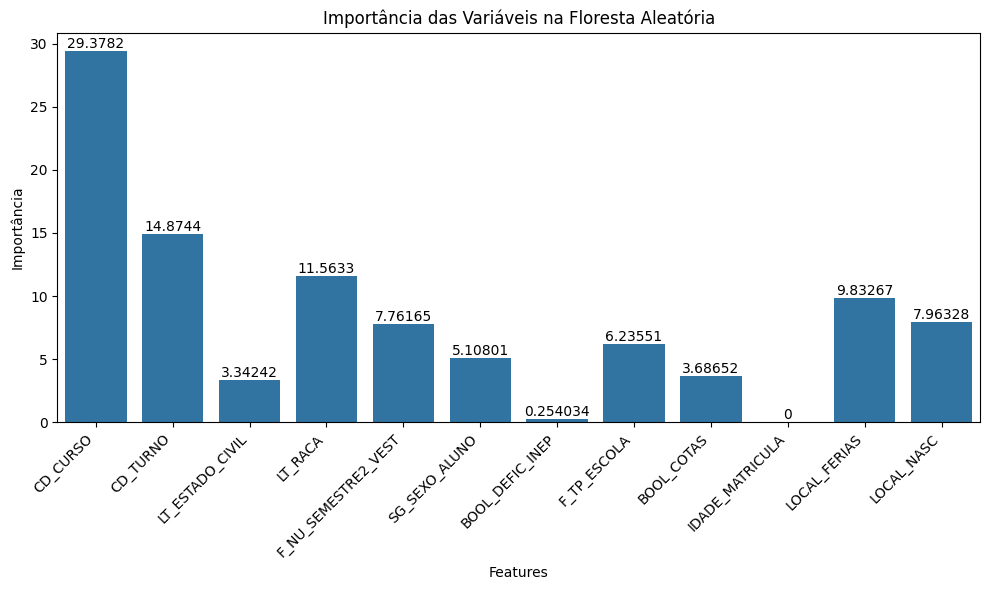

In [77]:
plt.figure(figsize=(10, 6))
vis = sns.barplot(x=feature_names, y=importances_dt)
for container in vis.containers:
        vis.bar_label(container)
plt.title("Importância das Variáveis na Floresta Aleatória")
plt.xlabel("Features")
plt.ylabel("Importância")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

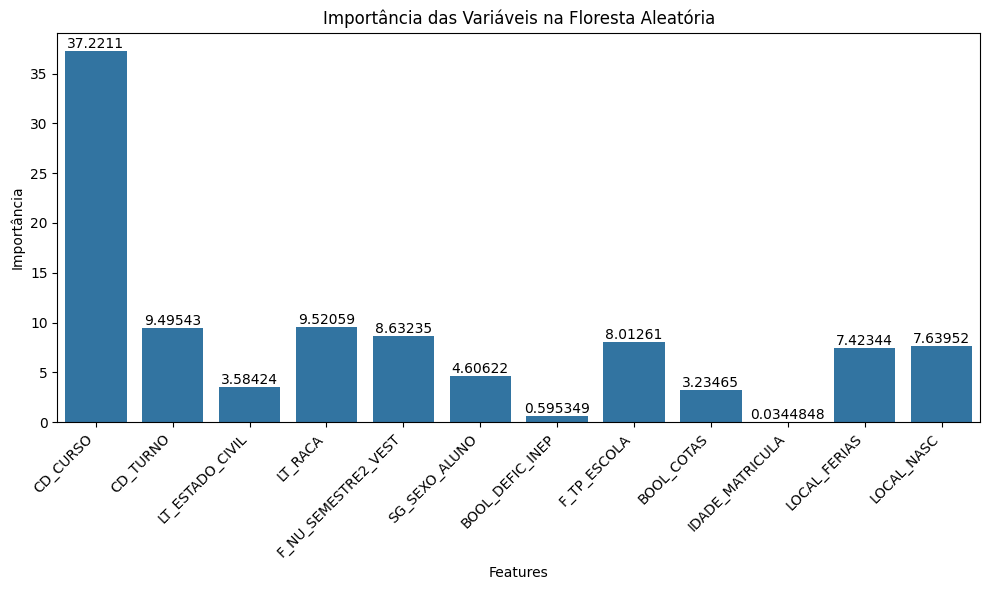

In [76]:
plt.figure(figsize=(10, 6))
vis = sns.barplot(x=feature_names, y=importances_rf)
for container in vis.containers:
        vis.bar_label(container)
plt.title("Importância das Variáveis na Floresta Aleatória")
plt.xlabel("Features")
plt.ylabel("Importância")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### XGBoost

In [80]:
xgb = xgb.XGBClassifier(objective='binary:logistic', random_state=42)

In [83]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.5, 0.8, 1.0],
    'colsample_bytree': [0.5, 0.8, 1.0],
    # 'reg_lambda': [0, 0.1, 1, 10]
}

In [84]:
xgb_grid = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=cv, n_jobs=-1, verbose=2)

In [85]:
xgb_grid.fit(X_train, y_train)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_typ...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.5, 0.8, 1.0],
                         'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 5, 7, 10],
                         'n_estimators': [50, 100, 200],
                         'subsample': [0.5, 0.8, 1.0]},
             verbose=2)

In [86]:
y_pred_xgb = xgb_grid.best_estimator_.predict(X_test)

In [87]:
print("Melhores parâmetros para XGBoost:", xgb_grid.best_params_)

Melhores parâmetros para XGBoost: {'colsample_bytree': 0.5, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 200, 'subsample': 1.0}


In [88]:
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print("Acurácia XGBoost:", accuracy_xgb)

precisao_xgb = precision_score(y_test, y_pred_xgb)
print("Precisão XGBoost:", precisao_xgb)

recall_xgb = recall_score(y_test, y_pred_xgb)
print("Recall XGBoost:", recall_xgb)

f1_xgb = f1_score(y_test, y_pred_xgb)
print("f1_score XGBoost:", f1_xgb)

Acurácia XGBoost: 0.684375935348698
Precisão XGBoost: 0.608564737370358
Recall XGBoost: 0.3737415245531128
f1_score XGBoost: 0.46308553971486766
